In [1]:
import sys
sys.path.append("..")

from pathlib import Path
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance, GroupSparseCovarianceCV

from bold_dementia.data.memento import Memento, MementoTS
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices

BIDSDIR = Path("/georges/memento/BIDS")
PPATH = Path("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv")
ATLAS = "harvard-oxford"
SOFT = False
CACHE_DIR = "/georges/memento/BIDS/derivatives/model_inputs/"
#CACHE_DIR = None
confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


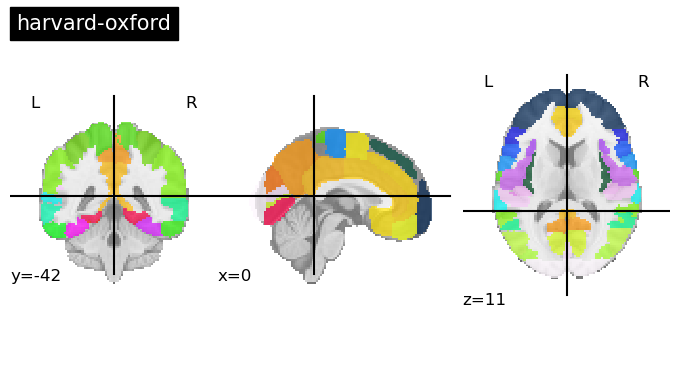

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.plot()
plotting.show()

In [3]:
if CACHE_DIR:
    memento = MementoTS(cache_dir=CACHE_DIR)
else:
    memento = Memento(BIDSDIR, PPATH, atlas)

res = next(iter(memento))
res

(array([[836.7375 , 901.25824, 943.78156, ..., 853.0887 , 832.60596,
         824.1409 ],
        [833.3899 , 897.8913 , 942.68024, ..., 846.9073 , 830.9035 ,
         820.0037 ],
        [836.2076 , 890.98773, 945.243  , ..., 843.96216, 823.0529 ,
         819.85205],
        ...,
        [837.0284 , 893.3379 , 947.43365, ..., 842.66327, 830.4003 ,
         821.52545],
        [835.07294, 896.47125, 943.58405, ..., 841.86304, 828.5284 ,
         821.2768 ],
        [833.38995, 896.16724, 942.54913, ..., 843.5592 , 825.68915,
         821.8512 ]], dtype=float32),
 False,
 'sub-0001_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz')

In [4]:
control_ts = []
AD_ts = []
pre_AD_ts = []

if CACHE_DIR:
    for ts, is_AD, _ in iter(memento):
        if is_AD:
            AD_ts.append(ts)
        else:
            control_ts.append(ts)
else:
    rs = memento.rest_dataset
    dement_mask = rs.scan_to_onset <= 0
    subsample = pd.concat([rs[dement_mask].sample(n=5), rs[rs.scan_to_onset.isna()].sample(n=5)])
    masker = atlas.fit_masker()
    for index, subrow in subsample.iterrows():
        print(f"Processing {subrow.file_basename}")
        # Preloading with nib is faster than passing a string path
        # to nilearn
        img = nib.load(subrow.file_path)
        confounds, sample_mask = load_confounds(
            subrow.file_path,
            **confounds_strategy
        )
        ts = masker.transform(img, confounds, sample_mask)
        print(subrow.scan_to_onset)
        if subrow.scan_to_onset <= 0:
            AD_ts.append(ts)
        elif math.isnan(subrow.scan_to_onset):
            control_ts.append(ts)
        else:
            pre_AD_ts.append(ts)

In [13]:
import random
random.seed(1)
control_ts_sub = random.choices(control_ts, k=len(AD_ts))
time_series = AD_ts + control_ts_sub
AD_indices = list(range(len(AD_ts)))
control_indices = list(range(len(AD_ts), len(time_series)))

In [14]:
from sklearn import covariance
from bold_dementia.models.transformers import ListScaler, Concatenator

# TODO Refactor with Connectivity measure 
# (if we can still use GroupSparseCovariance as estimator)

# The sample correlation matrix with relatively short time series
# is a bad estimate of functionnal connectivity
#pipe = Pipeline(
#    [
#        ("concat", Concatenator()),
#        ("scaler", StandardScaler()),
#        ("cov", covariance.GraphicalLasso(alpha=0.1)),
#    ]
#)
pipe = Pipeline(
    [
        ("scaler", ListScaler()),
        ("cov", GroupSparseCovariance(alpha=0.0011)), # Alpha found by CV
    ]
)

# Fit AD and controls together to have a common sparsity pattern,
# but is that a good idea?
pipe.fit(time_series)


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


Pipeline(steps=[('scaler', ListScaler()),
                ('cov', GroupSparseCovariance(alpha=0.0011))])

In [15]:
gcov = pipe.named_steps["cov"]
AD_cov = gcov.covariances_[:, :, AD_indices].mean(axis=2)
AD_prec = gcov.precisions_[:, :, AD_indices].mean(axis=2)

control_cov = gcov.covariances_[:, :, control_indices].mean(axis=2)
control_prec = gcov.precisions_[:, :, control_indices].mean(axis=2)

In [16]:

# TODO Macro labelling, should be added in atlases?
# TODO all those labels, refactor names
from matplotlib.ticker import FixedLocator

# TODO For clarity : more ticks?
def plot_matrices(cov, prec, title, labels, macro_labels=True):
    """Plot covariance and precision matrices.
    For macro labels only schaeffer has been tested so far
    """
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # We want network labels to span over several rows
    if macro_labels:
        labels = None
        networks = np.array(list(map(lambda x: str(x).split("_")[2], labels)))
        sort_index = np.argsort(networks)
        ticks = []
        lbls = []
        prev_label = None
        for i, label in enumerate(networks[sort_index]):
            if label != prev_label:
                ticks.append(i)
                lbls.append(label)
                prev_label = label
                ax1.hlines(i, 0, len(labels), colors="black", linestyles="dotted")
                ax2.hlines(i, 0, len(labels), colors="black", linestyles="dotted")
                ax1.vlines(i, 0, len(labels), colors="black", linestyles="dotted")
                ax2.vlines(i, 0, len(labels), colors="black", linestyles="dotted")

        ticks.append(i + 1)
        
    else:
        sort_index = np.arange(len(prec))

    sns.heatmap(cov[np.ix_(sort_index, sort_index)], ax=ax1, vmin=-1, vmax=1, cmap="seismic", yticklabels=labels)
    sns.heatmap(prec[np.ix_(sort_index, sort_index)], ax=ax2, cmap="seismic", vmin=-span, vmax=span)

    # This is a bit unstatisfying
    if macro_labels:
        ax1.yaxis.set_minor_locator(FixedLocator(ticks))
        ax1.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.set_yticklabels(lbls, rotation=0)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    return fig

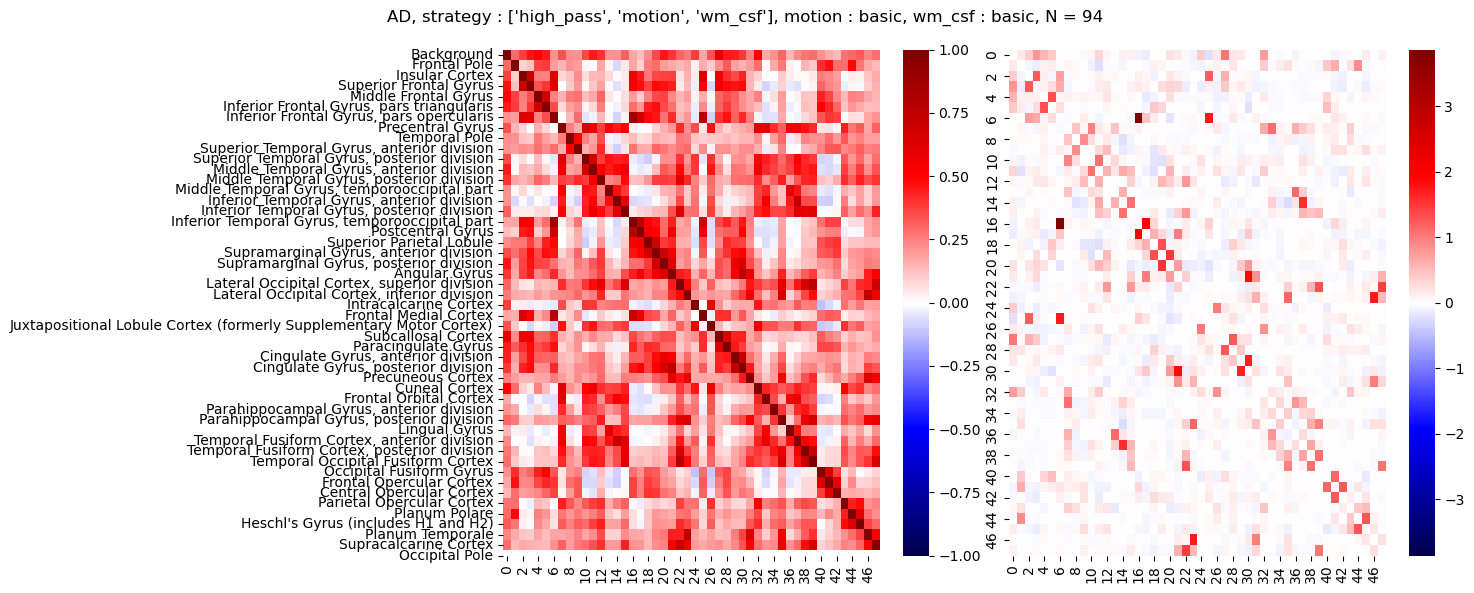

In [17]:
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

# Mean ou pas mean?
plot_matrices(AD_cov, -AD_prec, f"AD, {title}, N = {len(AD_ts)}", atlas.labels, macro_labels=False)

plotting.show()

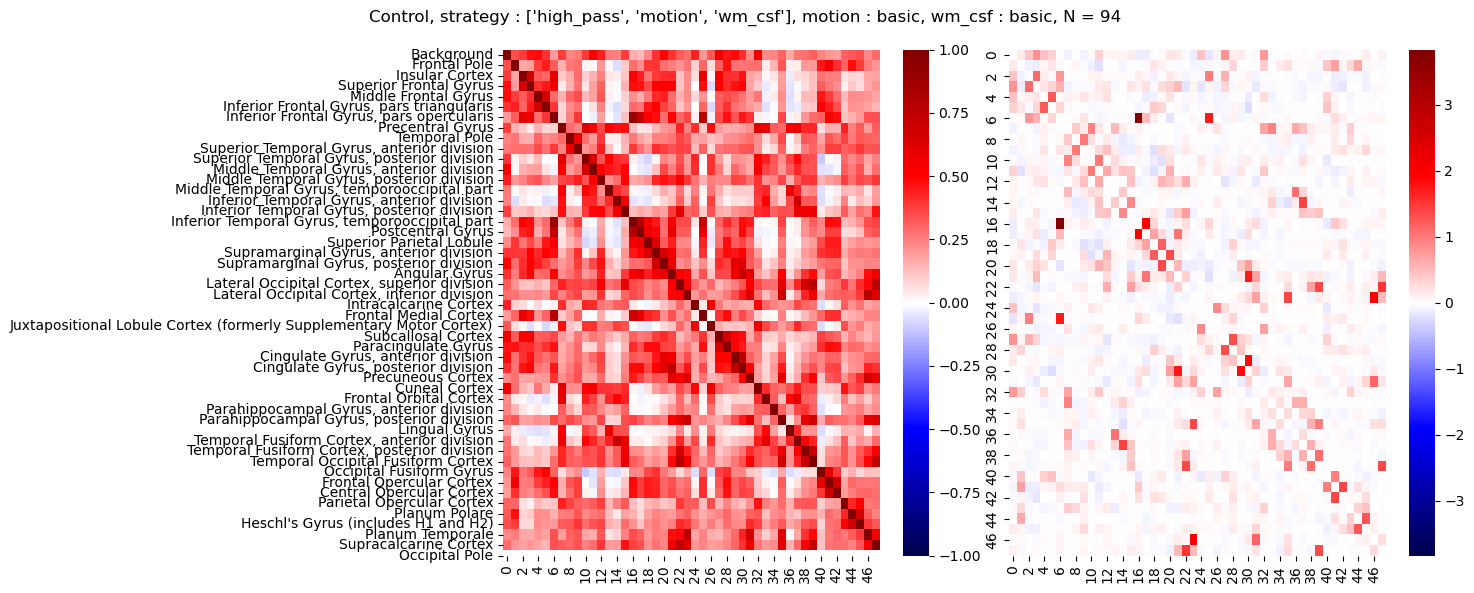

In [18]:
plot_matrices(control_cov, -control_prec, f"Control, {title}, N = {len(control_ts_sub)}", atlas.labels, macro_labels=False)

plotting.show()

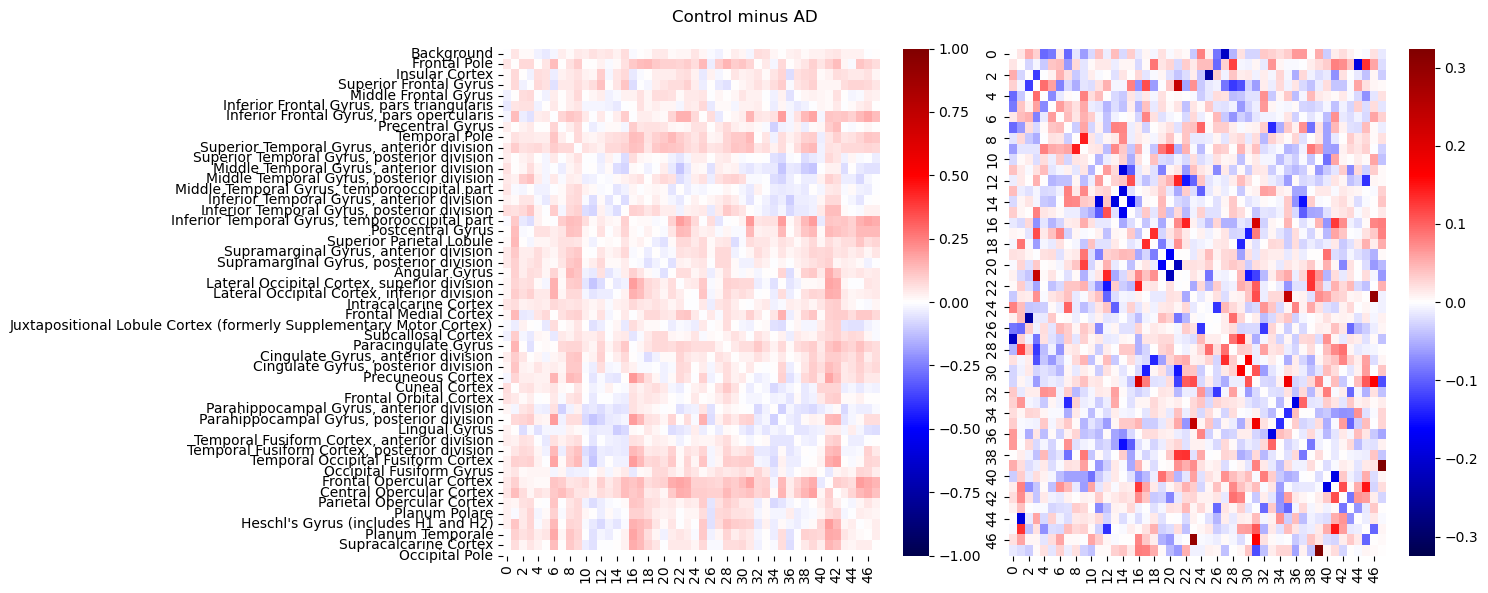

In [19]:
# TODO Same pipeline but shufle time series at the beginning to compare
plot_matrices(
    control_cov - AD_cov,
    -control_prec + AD_prec,
    "Control minus AD",
    atlas.labels,
    macro_labels=False
)
plotting.show()